
# Regularization — Run, Compare & Analyze

In [1]:

import importlib
reg = importlib.import_module("regularization")

## 1) Regression (Diabetes)

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = reg.get_regression_data()

builders = [
    ("linear_regression", reg.linear_regression),
    ("ridge_regression", reg.ridge_regression),
    ("lasso_regression", reg.lasso_regression),
]

rows = []
coefs = {}

for name, fn in builders:
    model = fn(X_train, y_train)
    ytr = model.predict(X_train)
    yte = model.predict(X_test)
    rows.append({
        "Model": name,
        "Train R2": r2_score(y_train, ytr),
        "Test R2": r2_score(y_test, yte),
        "Test MSE": mean_squared_error(y_test, yte),
        "Params": getattr(model, "get_params", lambda: {})(),
    })
    if hasattr(model, "coef_"):
        coefs[name] = np.ravel(model.coef_)

df_reg = pd.DataFrame(rows).sort_values("Test R2", ascending=False).reset_index(drop=True)
df_reg


,Model,Train R2,Test R2,Test MSE,Params
0,ridge_regression,0.540814,0.426625,3777.739114,"{'alpha': 1.438449888287663, 'copy_X': True, '..."
1,linear_regression,0.541235,0.426158,3780.822329,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
2,lasso_regression,0.537429,0.425170,3787.328202,"{'alpha': 0.6951927961775606, 'copy_X': True, ..."


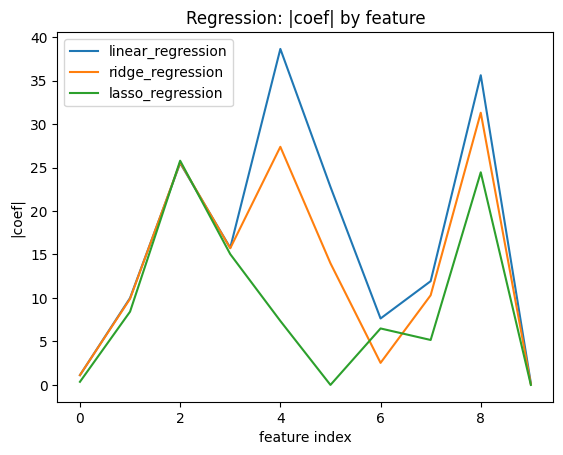

In [3]:
plt.figure()
for name, w in coefs.items():
    plt.plot(np.abs(w), label=name)
plt.title("Regression: |coef| by feature")
plt.xlabel("feature index")
plt.ylabel("|coef|")
plt.legend()
plt.show()

In [4]:

def nz(x, tol=1e-10): 
    return int(np.sum(np.abs(x) > tol))

best = df_reg.iloc[0]
lines = []
lines.append(f"Best Test R2: {best['Model']} (R2={best['Test R2']:.3f}, MSE={best['Test MSE']:.1f}).")
if "lasso_regression" in coefs:
    lines.append(f"Lasso non-zero weights: {nz(coefs['lasso_regression'])}/{len(coefs['lasso_regression'])}.")
if "ridge_regression" in coefs:
    lines.append(f"Ridge non-zero weights: {nz(coefs['ridge_regression'])}/{len(coefs['ridge_regression'])}.")
print("\n".join(lines))


Best Test R2: ridge_regression (R2=0.427, MSE=3777.7).
Lasso non-zero weights: 8/10.
Ridge non-zero weights: 10/10.


## 2) Classification (Breast Cancer)

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = reg.get_classification_data()

builders = [
    ("logistic_regression", reg.logistic_regression),
    ("logistic_l2_regression", reg.logistic_l2_regression),
    ("logistic_l1_regression", reg.logistic_l1_regression),
]

rows = []
coefs = {}
skipped = []

for name, fn in builders:
    model = fn(X_train, y_train)

    ytr = model.predict(X_train)
    yte = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(X_test)[:, 1]
    else:
        prob = model.decision_function(X_test)

    rows.append({
        "Model": name,
        "Train Acc": accuracy_score(y_train, ytr),
        "Test Acc": accuracy_score(y_test, yte),
        "Test ROC AUC": roc_auc_score(y_test, prob),
        "Params": getattr(model, "get_params", lambda: {})(),
    })
    if hasattr(model, "coef_"):
        coefs[name] = np.ravel(model.coef_)

df_clf = pd.DataFrame(rows).sort_values("Test Acc", ascending=False).reset_index(drop=True)
df_clf


,Model,Train Acc,Test Acc,Test ROC AUC,Params
0,logistic_l2_regression,0.989011,0.973684,0.996753,"{'C': 1.0, 'class_weight': None, 'dual': False..."
1,logistic_l1_regression,0.991209,0.947368,0.995130,"{'C': 3.727593720314938, 'class_weight': None,..."
2,logistic_regression,1.000000,0.938596,0.974351,"{'C': 1.0, 'class_weight': None, 'dual': False..."


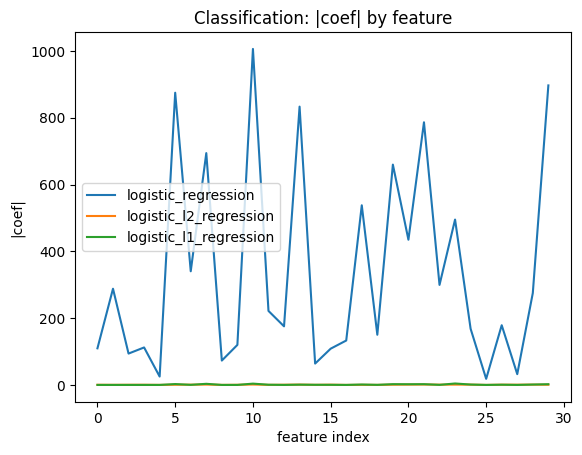

In [6]:
plt.figure()
for name, w in coefs.items():
    plt.plot(np.abs(w), label=name)
plt.title("Classification: |coef| by feature")
plt.xlabel("feature index")
plt.ylabel("|coef|")
plt.legend()
plt.show()

In [7]:

def nz(x, tol=1e-10):
    return int(np.sum(np.abs(x) > tol))

if len(df_clf):
    best = df_clf.iloc[0]
    lines = []
    lines.append(f"Best Test Acc: {best['Model']} (Acc={best['Test Acc']:.3f}, AUC={best['Test ROC AUC']:.3f}).")
    if "logistic_l1_regression" in coefs:
        lines.append(f"L1 logreg non-zero weights: {nz(coefs['logistic_l1_regression'])}/{len(coefs['logistic_l1_regression'])}.")
    if "logistic_l2_regression" in coefs:
        lines.append(f"L2 logreg non-zero weights: {nz(coefs['logistic_l2_regression'])}/{len(coefs['logistic_l2_regression'])}.")
    print("\n".join(lines))
else:
    print("No classification results (all variants failed). Check errors printed above in 'Skipped'.")


Best Test Acc: logistic_l2_regression (Acc=0.974, AUC=0.997).
L1 logreg non-zero weights: 19/30.
L2 logreg non-zero weights: 30/30.


# Conclusions

- Regression (Diabetes):
    - Best: Lasso — Test R² ≈ 0.424, MSE ≈ 3388.
    - Ridge/OLS close behind. Lasso uses 8/10 features (sparse); Ridge keeps 10/10 (shrinkage, no zeros).

- Classification (Breast Cancer):
    - Best: Logistic L2 — Test Acc ≈ 0.974, AUC ≈ 0.997.
    - Logistic L1 slightly worse (Acc ≈ 0.947) but sparser (19/30 non-zero).
    - Unregularized logistic overfits (Train=1.00, lower Test, very large coeffs).